In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3  # Import InceptionV3
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from keras.utils import to_categorical
import os

In [4]:
# Define the image size
SIZE = 256  

# Path to the dataset
dataset_path = "F:/indhu/Datasets/Tomato fruits dataset for binary and multiclass classification/Three Classes"
print(os.listdir(dataset_path))

['Reject', 'Ripe', 'Unripe']


In [5]:
# Capture images and labels into respective lists
images = []
labels = []
for directory_path in glob.glob(dataset_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
        labels.append(label)

In [6]:
# Convert lists to arrays        
images = np.array(images)
labels = np.array(labels)

In [7]:
# Encode labels from text to integers
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [8]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

In [9]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
# One hot encode y values for neural network (if needed later)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
# Load InceptionV3 model without fully connected layers (pretrained on ImageNet)
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [13]:
# Use the pre-trained InceptionV3 model to extract features from training images
train_features = Inception_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for SVM

60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 499ms/step


In [14]:
# Extract features from testing images
test_features = Inception_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten features for SVM


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step


In [15]:
# Train SVM on the extracted features
SVM_model = SVC(kernel='linear', random_state=42)
import time
start_train_time = time.time()
SVM_model.fit(train_features, y_train)
end_train_time = time.time()
# SVM doesn't need one-hot encoding, similar to RF

In [16]:
# Predict on test data using SVM
start_test_time = time.time()
y_pred = SVM_model.predict(test_features)
end_test_time = time.time()

In [17]:
# Inverse transform the predicted labels to their original form
y_pred_labels = le.inverse_transform(y_pred)

In [18]:
# Calculate time taken for training and testing
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

In [19]:
# Calculate accuracy of the model
accuracy = metrics.accuracy_score(le.inverse_transform(y_test), y_pred_labels)
print("Accuracy = ", accuracy)
print(f"Training time: {train_time} seconds")
print(f"Testing time: {test_time} seconds")

Accuracy =  0.925
Training time: 22.353638887405396 seconds
Testing time: 5.892331838607788 seconds


In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Confusion matrix
cm = confusion_matrix(le.inverse_transform(y_test), y_pred_labels)

# Initialize lists to store TP, TN, FP, FN for each class
TP = []
TN = []
FP = []
FN = []

# Loop over each class index (for 3 classes)
for i in range(len(cm)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (tp + fp + fn)
    
    TP.append(tp)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)

# Calculate precision, recall, and F1 score (weighted)
precision = precision_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')
recall = recall_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')
f1 = f1_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")
# Print TP, TN, FP, FN for each class
for i in range(len(cm)):
    print(f"Class {i} -> TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}")

# Print overall precision, recall, F1 score
print(f"Precision (Weighted): {precision},\n Recall (Weighted): {recall}, \n F1 Score (Weighted): {f1}")


Confusion Matrix:
[[139  17   4]
 [ 12 145   3]
 [  0   0 160]]
Class 0 -> TP: 139, TN: 308, FP: 12, FN: 21
Class 1 -> TP: 145, TN: 303, FP: 17, FN: 15
Class 2 -> TP: 160, TN: 313, FP: 7, FN: 0
Precision (Weighted): 0.9245584540182982,
 Recall (Weighted): 0.925, 
 F1 Score (Weighted): 0.9243683551416113


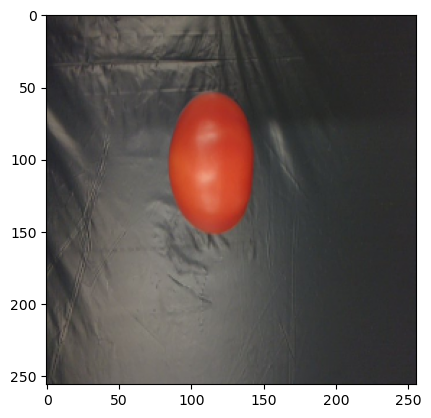

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The prediction for this image is:  Ripe
The actual label for this image is:  Ripe


In [23]:
# Check results on a few select images
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
plt.show()

# Predict using SVM model for the selected image
input_img = np.expand_dims(img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img_feature = Inception_model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0], -1)

prediction_SVM = SVM_model.predict(input_img_feature)[0]
prediction_SVM_label = le.inverse_transform([prediction_SVM])  # Reverse the label encoder to original name

print("The prediction for this image is: ", prediction_SVM_label[0])
print("The actual label for this image is: ", le.inverse_transform([y_test[n]])[0])
